In [ ]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt


# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [25]:
# Read in the dataset as a dataframe
train = pd.read_csv('house-prices-advanced-regression-techniques\\train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques\\test.csv')
train.shape,test.shape

((1460, 81), (1459, 80))

In [26]:
# Preview the data we're working with
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


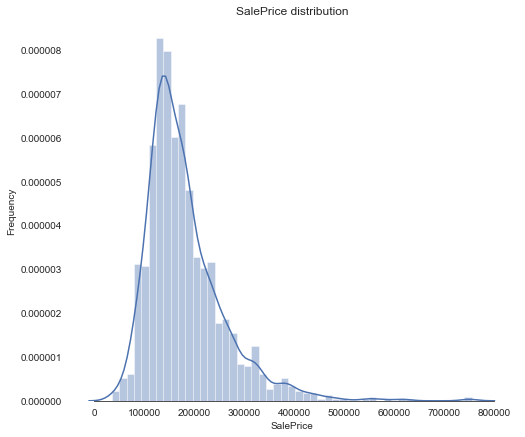

In [27]:
# 标签值分布可视化
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [28]:
# Skew and kurt 

# 偏度（Skewness）是描述数据分布形态的统计量，其描述的是某总体取值分布的对称性，简单来说就是数据的不对称程度。。
# 偏度是三阶中心距计算出来的。
# （1）Skewness = 0 ，分布形态与正态分布偏度相同。
# （2）Skewness > 0 ，正偏差数值较大，为正偏或右偏。长尾巴拖在右边，数据右端有较多的极端值。
# （3）Skewness < 0 ，负偏差数值较大，为负偏或左偏。长尾巴拖在左边，数据左端有较多的极端值。
# （4）数值的绝对值越大，表明数据分布越不对称，偏斜程度大。
# | Skewness| 越大，分布形态偏移程度越大。

# 峰度（Kurtosis）偏度是描述某变量所有取值分布形态陡缓程度的统计量，简单来说就是数据分布顶的尖锐程度。
# 峰度是四阶标准矩计算出来的。
# （1）Kurtosis=0 与正态分布的陡缓程度相同。
# （2）Kurtosis>0 比正态分布的高峰更加陡峭——尖顶峰
# （3）Kurtosis<0 比正态分布的高峰来得平台——平顶峰

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


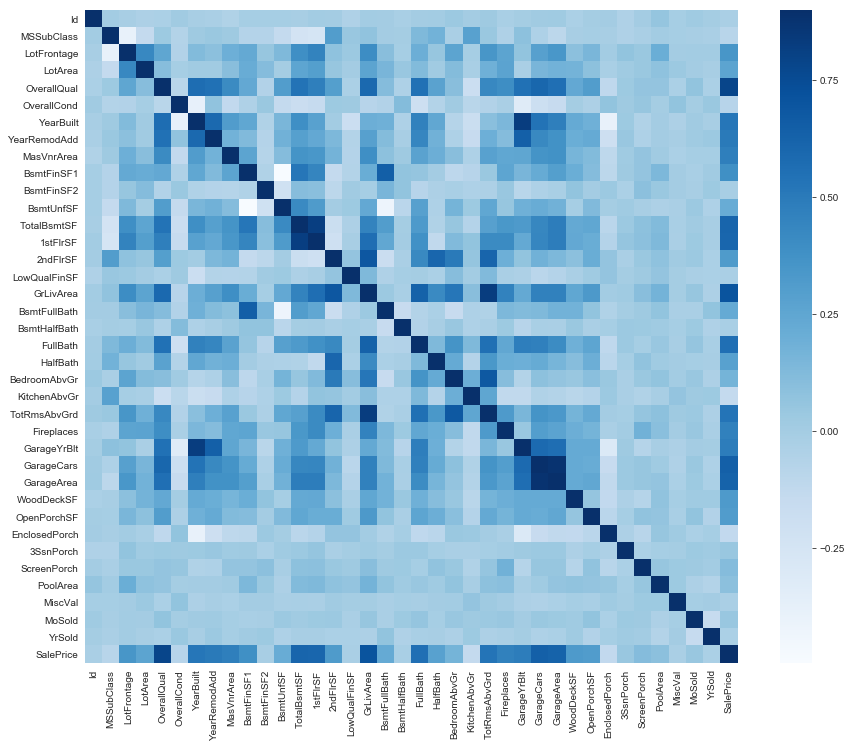

In [29]:
# 分析数据特征间相关性
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [ ]:
# g1 = sns.pairplot(train)

In [ ]:
# g2 = sns.pairplot(train, hue="SalePrice")

In [30]:
# 查看数据特征
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

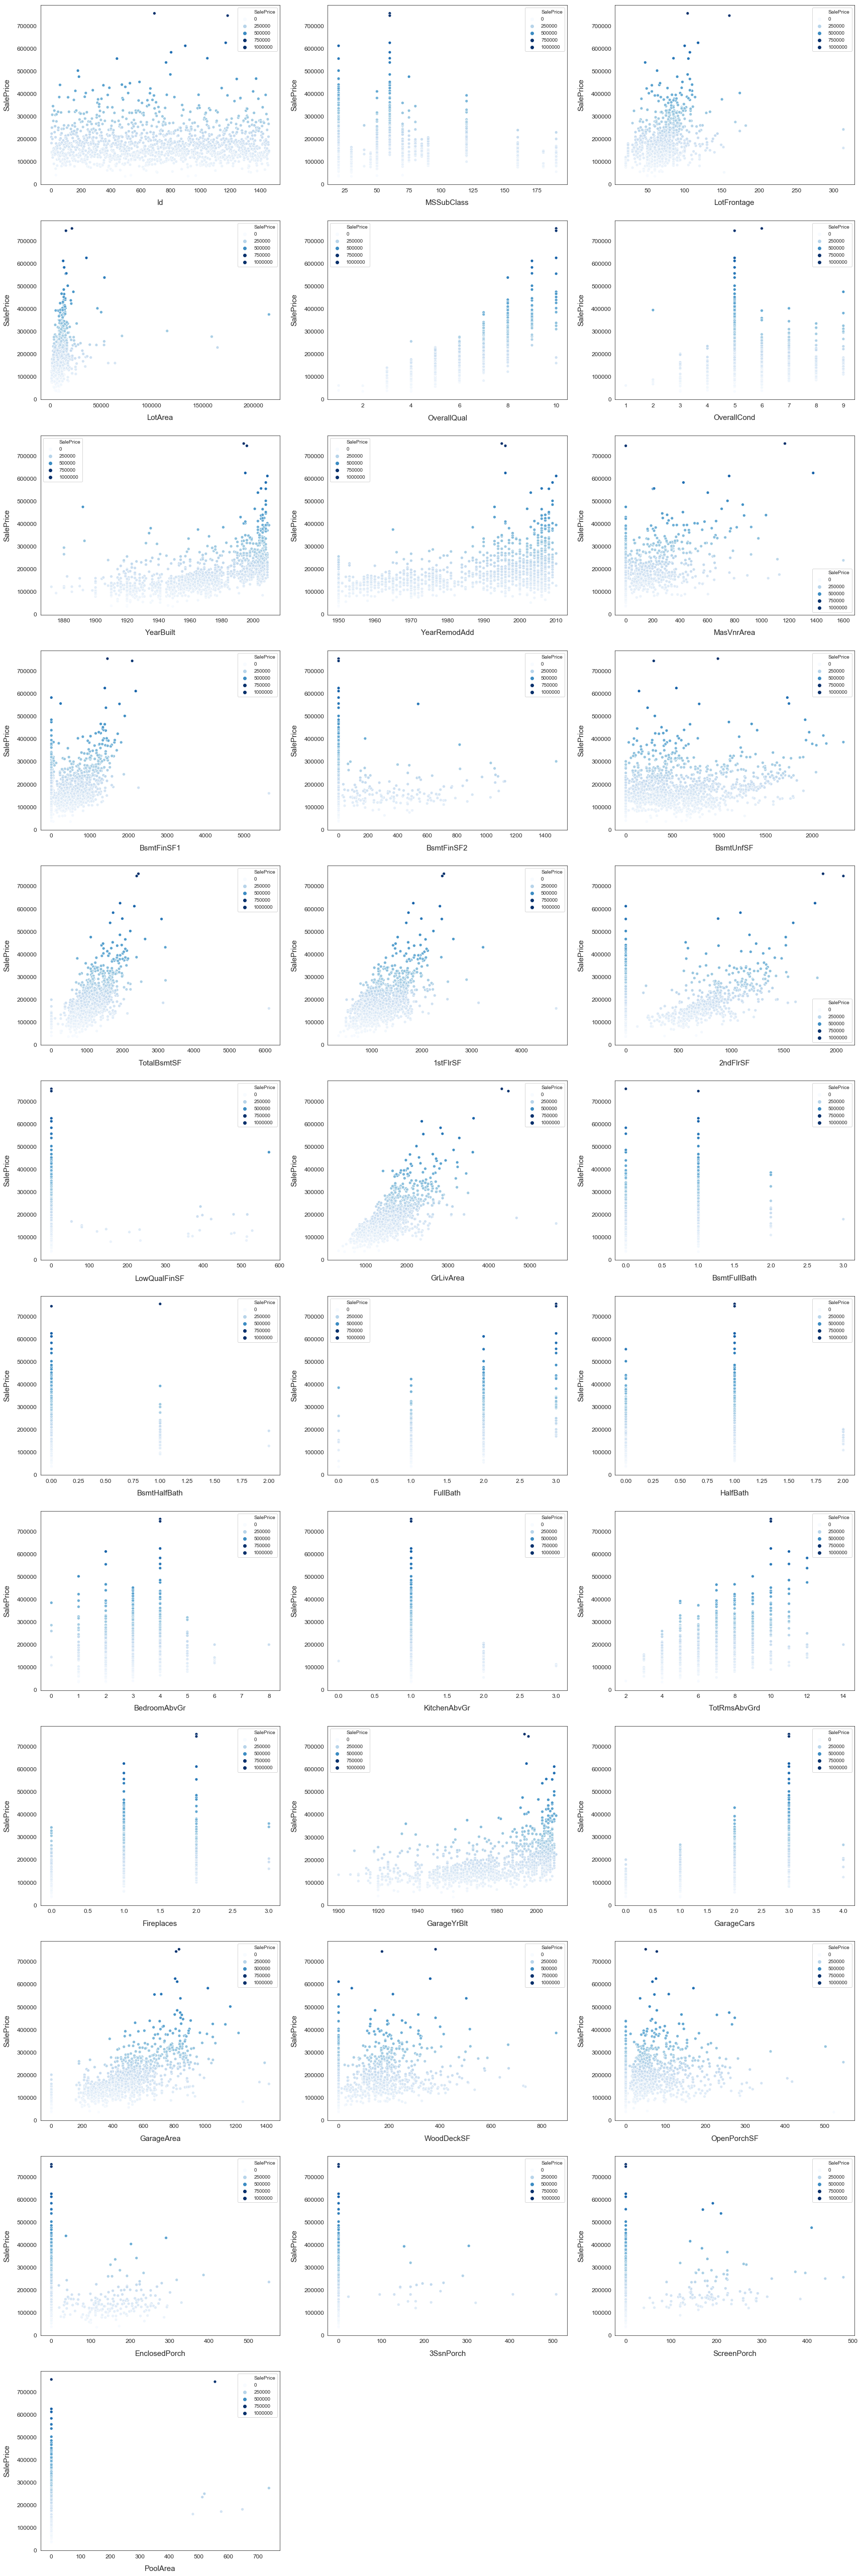

In [33]:
# 寻找数值型特征
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        numeric.append(i)
# 可视化数据值中的一些异常值
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

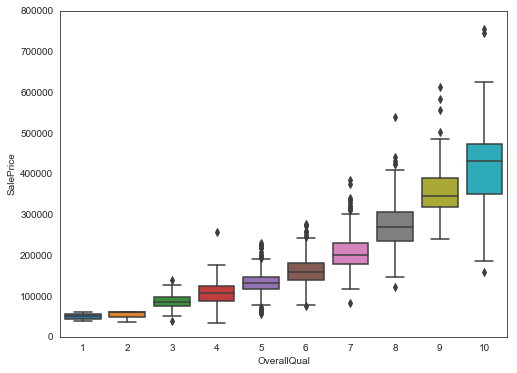

In [34]:
# 查看具体的数据特征（OverallQual）与SalePrice 的相关性
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

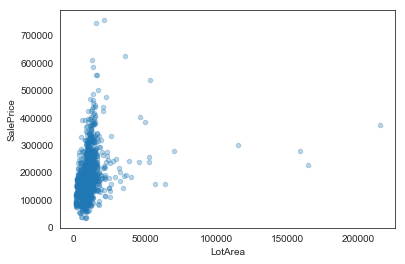

In [38]:
# 分析LotArea与房价的散点图关系（可视化相关性不大且存在异常点/关联性极低点）
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3)

In [39]:
# 由于标签值向右倾斜，大多数机器学习模型对非正态分布的数据的效果不佳，因此，我们对数据进行变换，修正这种倾斜：log(1+x) 

# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



<function matplotlib.pyplot.show(*args, **kw)>

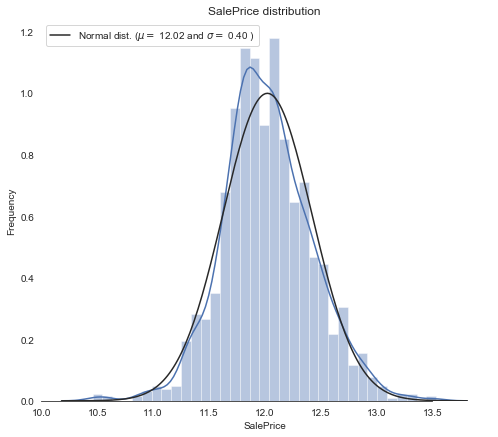

In [43]:
# 对SalePrice再次可视化
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
# 确认新的分布
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# 获取函数所使用的拟合参数
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 绘制新的分布
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show

In [44]:
# 删除异常值
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [45]:
# 合并训练集和测试集，并分割数据特征与标签
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 80)

In [48]:
# 填补缺失值（统计缺失值率）
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

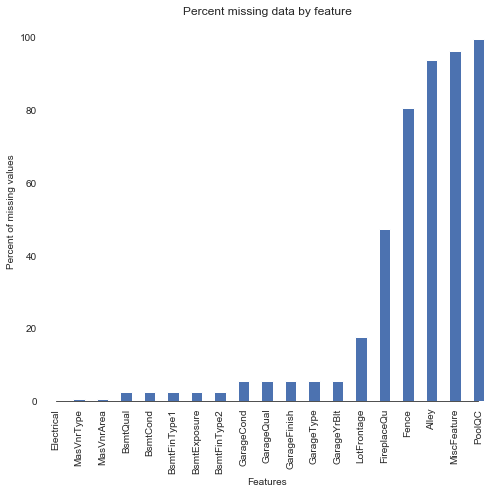

In [49]:
# 可视化缺失值比率
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [50]:
# 一些非数字谓词存储为数字;把它们转换成字符串
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)#销售年份
all_features['MoSold'] = all_features['MoSold'].astype(str)#销售月份

In [51]:
# 处理缺失值
def handle_missing(features):
    # 选择众数填充
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])# mode()[0]获得列的众数
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # 用0替换缺失值，因为没有garage =车库中没有汽车
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # 用None替换缺失值
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN值对于这些分类基底特征，意味着没有基底
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # 按社区分组，并按社区的LotFrontage中值填充缺失值
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # 对于如何填充其余的分类特征，我们没有特别的直觉，所以我们用None替换它们缺失的值
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))
    return features

all_features = handle_missing(all_features)

In [52]:
# 确认是否存在缺失值
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('Id', 0.0),
 ('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0)]

In [53]:
# 获得数值特征
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

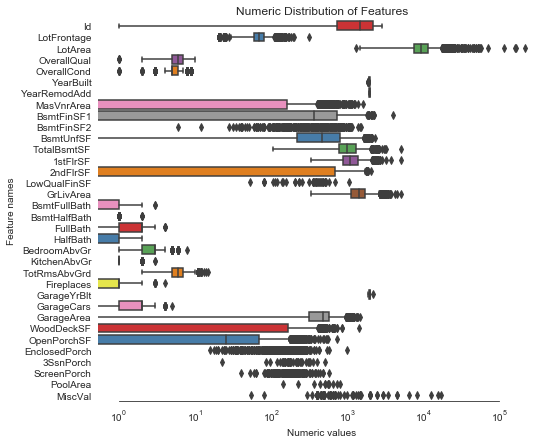

In [54]:
# 可视化数值特征
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [55]:
# 找到倾斜的数值特征
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

In [56]:
# 使用 scipy 的函数 boxcox1来进行 Box-Cox 转换，将数据正态化
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i],boxcox_normmax(all_features[i] + 1))

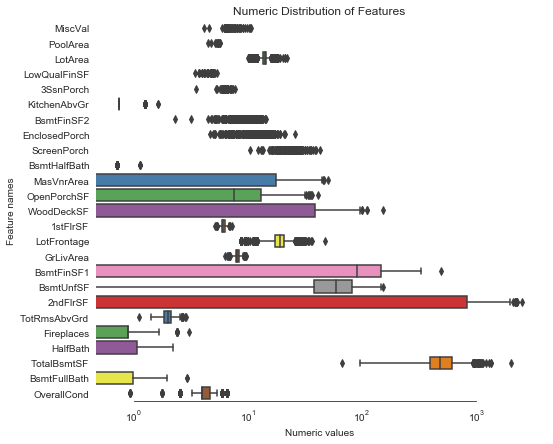

In [57]:
# 检查数据特征是否均满足正态分布
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [59]:
# 产生新的数据特征
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)


all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [61]:
# 特征转换:通过对特征取对数或者平方，可以创造更多的特征，这些操作有利于发掘潜在的有用特征。

def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [62]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['YearRemodAdd', 'LotFrontage_log',
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

In [63]:
# 对集合特征进行数值编码，使得机器学习模型能够处理这些特征。
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 380)

In [64]:
all_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,18.144572,13.833055,7,3.991517,2003,2003,19.433174,144.117862,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20.673624,14.117918,6,6.000033,1976,1976,54.598150,181.719186,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,18.668045,14.476513,7,3.991517,2001,2002,17.768840,110.441033,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,17.249650,14.106197,7,3.991517,1915,1970,54.598150,61.795315,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,21.314281,15.022009,8,3.991517,2000,2000,25.404163,136.624601,0.0,...,0,0,0,1,0,0,0,0,1,0


In [65]:
# 去除重复特征
all_features = all_features.loc[:,~all_features.columns. duplicated()]
all_features.shape

(2917, 379)

In [66]:
# 重新获得训练集和测试集
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 379), (1458,), (1459, 379))

In [67]:
# 初始化交叉验证
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# 定义误差评估指标
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [68]:
# 构建模型
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression',
                       num_leaves=6,
                       learning_rate=0.01,
                       n_estimators=7000,
                       max_bin=200,
                       bagging_fraction=0.8,
                       bagging_freq=4,
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)


# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))


# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))


# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)


# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)


# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [69]:
# 计算每个模型的交叉验证的得分
scores = {}
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1173 (0.0163)


In [70]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[23:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:23:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:25:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:26:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:26:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:52] WARNI

In [71]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1095 (0.0198)


In [ ]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1101 (0.0161)


In [ ]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

In [ ]:
# 拟合模型
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

In [ ]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

In [ ]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

In [ ]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

In [ ]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

In [ ]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

In [ ]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

In [ ]:
# 混合模型，以使最终的预测更健壮，以过度拟合
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [ ]:
# 从混合模型中获得最终的参数
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

In [ ]:
# 绘制各模型预测得分
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show

In [ ]:
# 读取提交示范代码格式
submission = pd.read_csv("house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

In [ ]:
# 调整混合模型的预测
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))
 
# 修复异常点的预测值
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [ ]:
# 比例缩放
submission['SalePrice'] *= 1.001619
submission.to_csv("submission_regression2.csv", index=False)